In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [25]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, \
                    pred_to_perf, prob_to_pred, prob_to_pred_2
from test import get_training_processed_data
from sklearn.model_selection import train_test_split

In [36]:
indices_price = pd.read_excel('data/indices_prices.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 5, 6, 7])
indices_price.to_csv('data/prices.csv')

In [37]:
bench_price, df_X, target_prices = get_price_data()
daily_returns = target_prices.pct_change()

In [38]:
target_prices.head()

,SMALL,MID,LARGE
1999-01-01,NaN,NaN,NaN
1999-01-04,3455.04,3895.44,4673.95
1999-01-05,3455.06,3943.97,4850.74
1999-01-06,3467.39,3962.71,4918.32
1999-01-07,3486.85,3997.35,4999.81


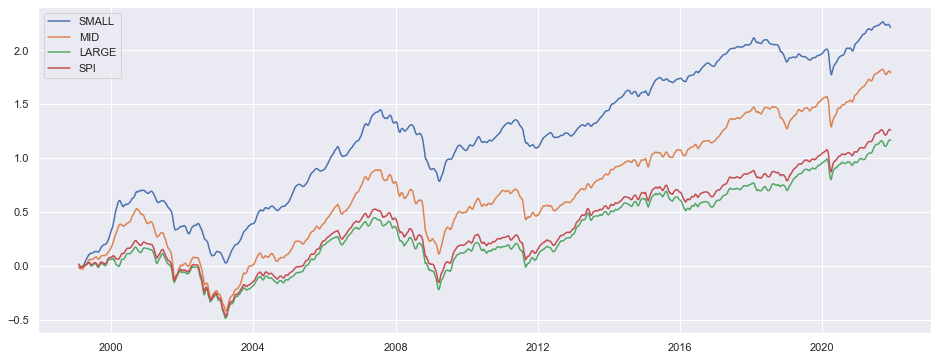

In [39]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = np.log((pd.concat([target_prices, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.show()

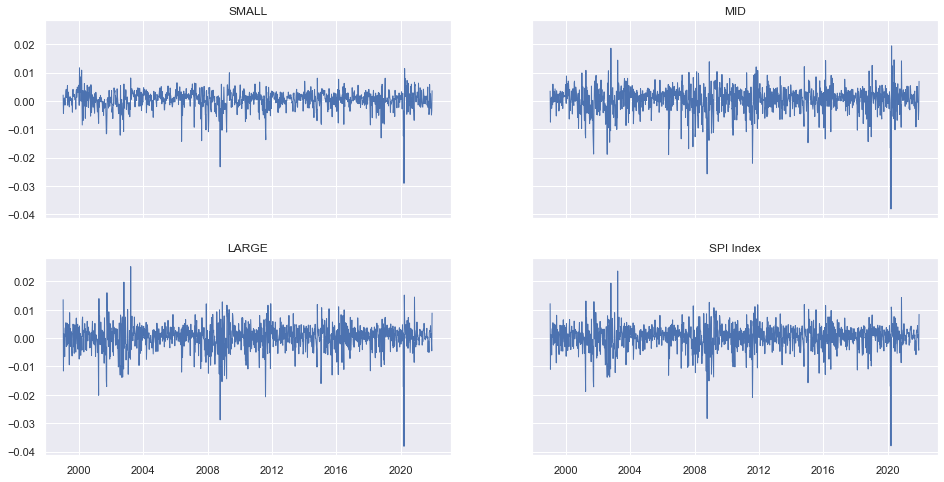

In [40]:
fix, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.ravel()

weekly_returns = pd.concat([target_prices, bench_price], axis=1).pct_change().resample('W').mean()
for i, ticker in enumerate(weekly_returns.columns):
    sns.lineplot(ax=axs[i], data=weekly_returns[ticker], lw=1)
    axs[i].set_ylabel(None)
    axs[i].set_title(ticker)

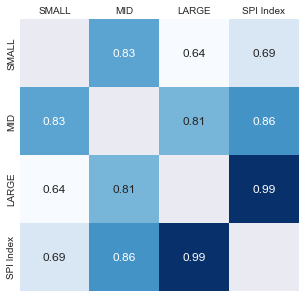

In [41]:
corr = pd.concat([target_prices, bench_price], axis=1).pct_change().resample('W').mean().corr().round(4)

fig, ax = plt.subplots(figsize=(5,5))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='Blues', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, labeltop=True, length=0)
plt.show()

In [42]:
data_stats = pd.concat([target_prices, bench_price], axis=1)
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
SMALL,9.78,9.88,0.99
MID,8.73,15.31,0.57
LARGE,6.56,17.77,0.37
SPI Index,6.80,16.89,0.40


In [43]:
rebalance_freq = 'W-FRI'
returns = target_prices.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

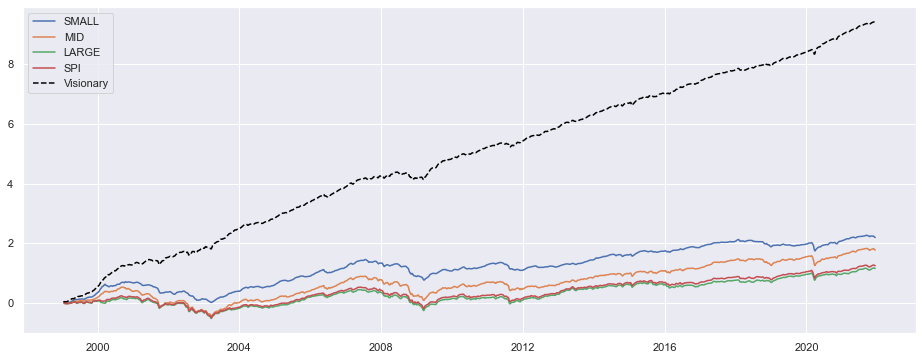

In [44]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((pd.concat([target_prices, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

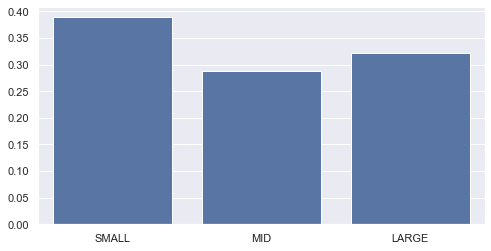

In [45]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

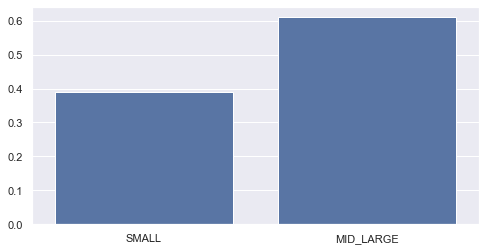

In [46]:
best_pred['MID_LARGE'] = ((best_pred.MID == 1) | (best_pred.LARGE == 1)).astype(int)

L = len(best_pred)
df_results = (best_pred[['SMALL', 'MID_LARGE']].sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

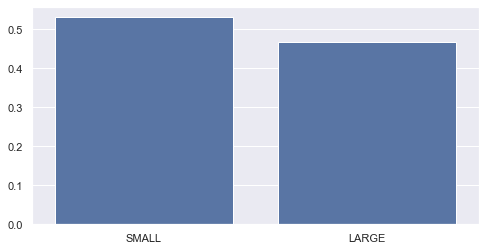

In [47]:
rebalance_freq = 'W-FRI'
returns = target_prices[['SMALL', 'LARGE']].pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 1.}).shift(-1)

L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [58]:

def last_friday(date):
    delta_days = 4 - date.weekday()
    if delta_days > 0:
        delta_days -= 7
    last_friday = date + relativedelta(days=delta_days)
    return last_friday

from dateutil.relativedelta import relativedelta

In [61]:
input_period = 42
df_input_all = df_X
training_window = 5

last_date = target_prices.index[-1]

last_date_train = last_friday(target_prices.index[-input_period])

num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

# Target data
returns = target_prices[:last_date_train].resample(rebalance_freq).apply(lambda x: np.log(x[-1] / x[0]) / len(x))

best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

start_date = last_friday(last_date_train - relativedelta(years=training_window))

df_output = best_pred.loc[start_date:].dropna()
df_output_reg = returns.shift(-1).loc[start_date:].dropna()

start_date_input = target_prices.loc[:start_date].iloc[-input_period:].index[0]

df_input = df_input_all.loc[start_date_input:df_output.index[-1]]
df_input_reg = target_prices.resample('W-FRI').apply(lambda x: np.log(x[-1] / x[0]) / len(x)).loc[start_date_input:df_output.index[-1]]

In [64]:
for idx in df_output.index:
    # If we rebalance monthly, the input data will be weekly data
    if rebalance_freq == 'M':
        dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
        reb_freq_input = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
        df_input_period = df_input.loc[:idx].resample(reb_freq_input).mean().iloc[-input_period:]
    # If we rebalance weekly, the input data will be daily data
    else:
        df_input_period = df_input.loc[:idx].iloc[-input_period:]
        df_input_period_reg = df_input_reg.loc[:idx].iloc[-input_period:]

In [66]:
df_input_period.tail()

SPI19 Index                                                                        SMCI Index                                                                        SPI21 Index            \
                  ma50       mo1        vol1      RSI9        MACD   MACD_diff weekly_returns       ma50       mo1        vol1      RSI9        MACD   MACD_diff weekly_returns        ma50       mo1   
2021-09-27    0.001873 -0.000314  299.894752  0.415446    2.053506  -72.976362       0.001174  -0.004732 -0.000857  264.779612  0.418626  -47.831620  -53.217969       0.001987   -0.028610 -0.002263   
2021-09-28   -0.003457 -0.000773  317.355517  0.398659  -20.956711  -76.789263       0.000589  -0.020225 -0.001848  298.753869  0.323440  -82.313333  -70.159746      -0.001514   -0.039763 -0.002824   
2021-09-29   -0.021788 -0.001852  391.624997  0.332579  -85.853642 -113.348955      -0.004355  -0.048351 -0.002826  399.926015  0.262018 -160.860165 -118.965262      -0.008575   -0.056732 -0.003535   
2021-09-30   -0.023307 -0.002180  448.535373  0.230122 -139.830285 -133.860478      -0.006081  -0.045391 -0.003078  468.379040  0.217606 -216.112866 -139.374370      -0.009841   -0.043227 -0.003004   
2021-10-01   -0.017177 -0.001998  464.292315  0.277917 -164.767195 -127.037911      -0.003669  -0.042017 -0.003185  506.103638  0.251874 -251.787513 -140.039214      -0.007671   -0.041238 -0.002924   

                                                                       MXEU0MT Index                                                                   MXEU0CS Index                                \
                  vol1      RSI9        MACD  MACD_diff weekly_returns          ma50       mo1       vol1      RSI9      MACD MACD_diff weekly_returns          ma50       mo1      vol1      RSI9   
2021-09-27  270.374815  0.346966 -133.353864 -39.466301       0.000860     -0.058764 -0.003530  10.064028  0.262120 -6.256411 -1.484008       0.003775     -0.016023 -0.000887  2.351916  0.393914   
2021-09-28  281.550074  0.271870 -149.847844 -44.768225      -0.002093     -0.065212 -0.003947  10.208914  0.263564 -6.448205 -1.340642       0.001318     -0.020532 -0.001217  2.399939  0.370135   
2021-09-29  309.085202  0.243756 -180.843094 -60.610780      -0.006376     -0.078191 -0.004181  10.458085  0.239430 -6.887951 -1.424310      -0.004345     -0.030941 -0.001572  2.646048  0.342647   
2021-09-30  313.288883  0.315097 -188.694495 -54.769744      -0.005408     -0.075047 -0.003828  10.649130  0.267402 -7.105325 -1.313347      -0.005832     -0.020943 -0.001240  2.642285  0.454094   
2021-10-01  308.009306  0.355845 -191.001951 -45.661760      -0.002946     -0.066181 -0.003514  10.627983  0.416530 -6.993634 -0.961325      -0.002254     -0.023785 -0.001272  2.595968  0.444444   

                                              MXEU0IN Index                                                                  MXEU0CD Index                                                    \
                MACD MACD_diff weekly_returns          ma50       mo1      vol1      RSI9      MACD MACD_diff weekly_returns          ma50       mo1      vol1      RSI9      MACD MACD_diff   
2021-09-27 -1.341837  0.021320       0.001573      0.000670 -0.000520  3.066045  0.451872 -0.015893 -0.470880       0.003662     -0.017621 -0.000053  2.934167  0.437786 -1.386001  0.073609   
2021-09-28 -1.455292 -0.073708      -0.001709     -0.006144 -0.000878  3.204837  0.414823 -0.266375 -0.577089       0.000383     -0.020674 -0.000143  2.954079  0.441828 -1.335206  0.099523   
2021-09-29 -1.775688 -0.315284      -0.004651     -0.032222 -0.001857  4.198236  0.360639 -1.136052 -1.157413      -0.007263     -0.043351 -0.001386  3.290804  0.424767 -1.672673 -0.190355   
2021-09-30 -1.794282 -0.267102      -0.002998     -0.026438 -0.001796  4.726918  0.322572 -1.648921 -1.336226      -0.007538     -0.031319 -0.001614  3.403602  0.455004 -1.722566 -0.192198   
2021-10-01 -1.861792 -0.267689      -0.001949     -0.031304 -0.0

In [67]:
df_input_period_reg.tail()

,SMALL,MID,LARGE
2021-09-03,0.003400,0.002108,-0.000169
2021-09-10,-0.001886,-0.001562,-0.003678
2021-09-17,0.000623,0.000256,-0.000321
2021-09-24,-0.001410,0.000073,0.000354
2021-10-01,-0.003669,-0.007671,-0.002946


In [21]:
ads_input = bench_price.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).rolling(42).apply(lambda x: adfuller(x)[0])
ads_mean_input = adfuller(bench_price.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).rolling(42).mean().dropna())[0]
print('ADS within each sample (SPI)', ads_input.mean())
print('ADS between each sample (SPI)', ads_mean_input)

ADS within each sample (SPI) -2.551167272569375
ADS between each sample (SPI) -11.569187698386589


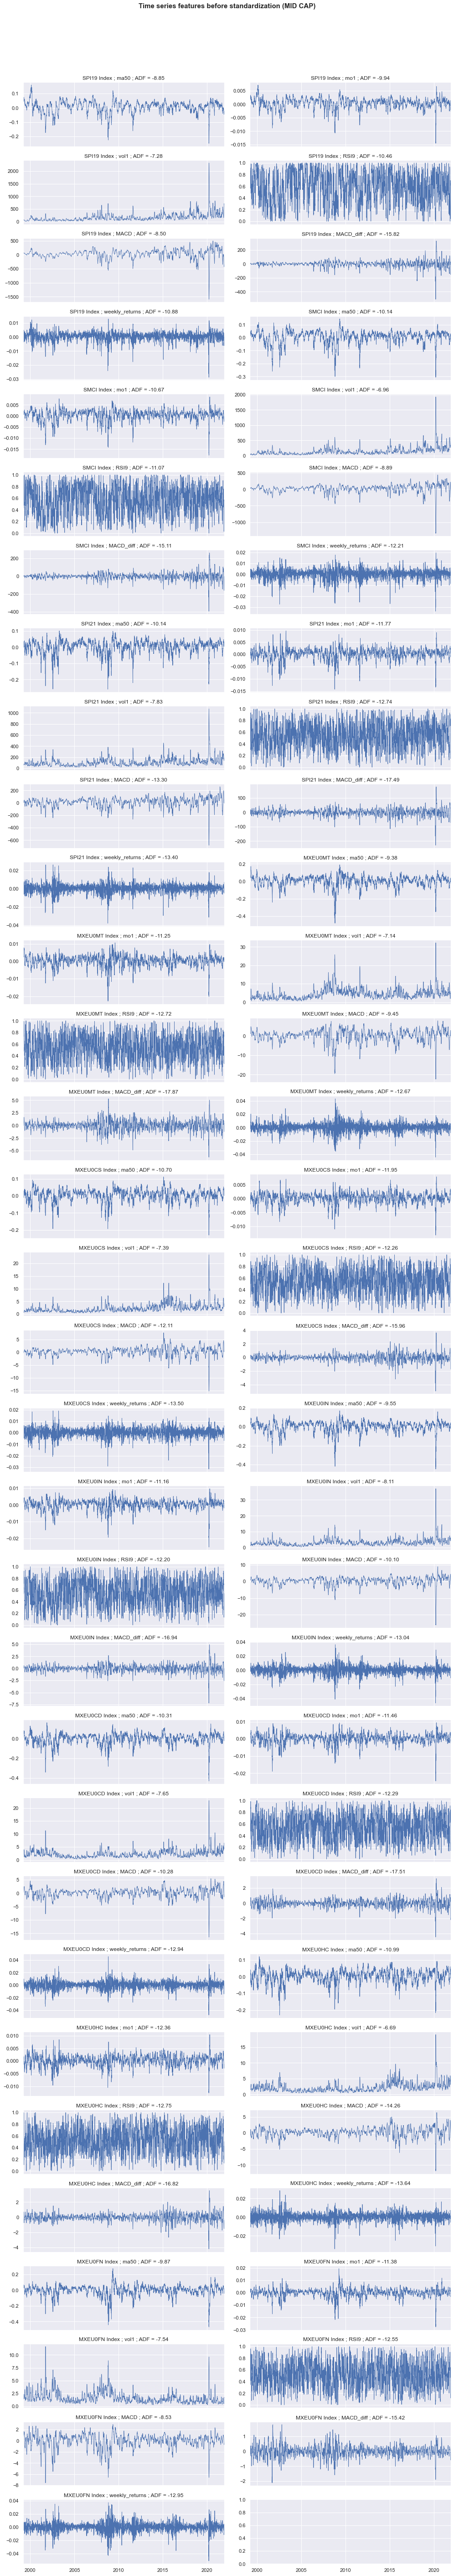

In [49]:
data_plot = df_X

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature // 2 + (number_feature % 2 > 0), 2, figsize=(14, 80), sharex=True)
axs = axs.ravel()
for i, col in enumerate(data_plot.columns):
    results = adfuller(data_plot[col].values)
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col[0] + ' ; ' + col[1] + f' ; ADF = {results[0]:.2f}')
    
plt.suptitle('Time series features before standardization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

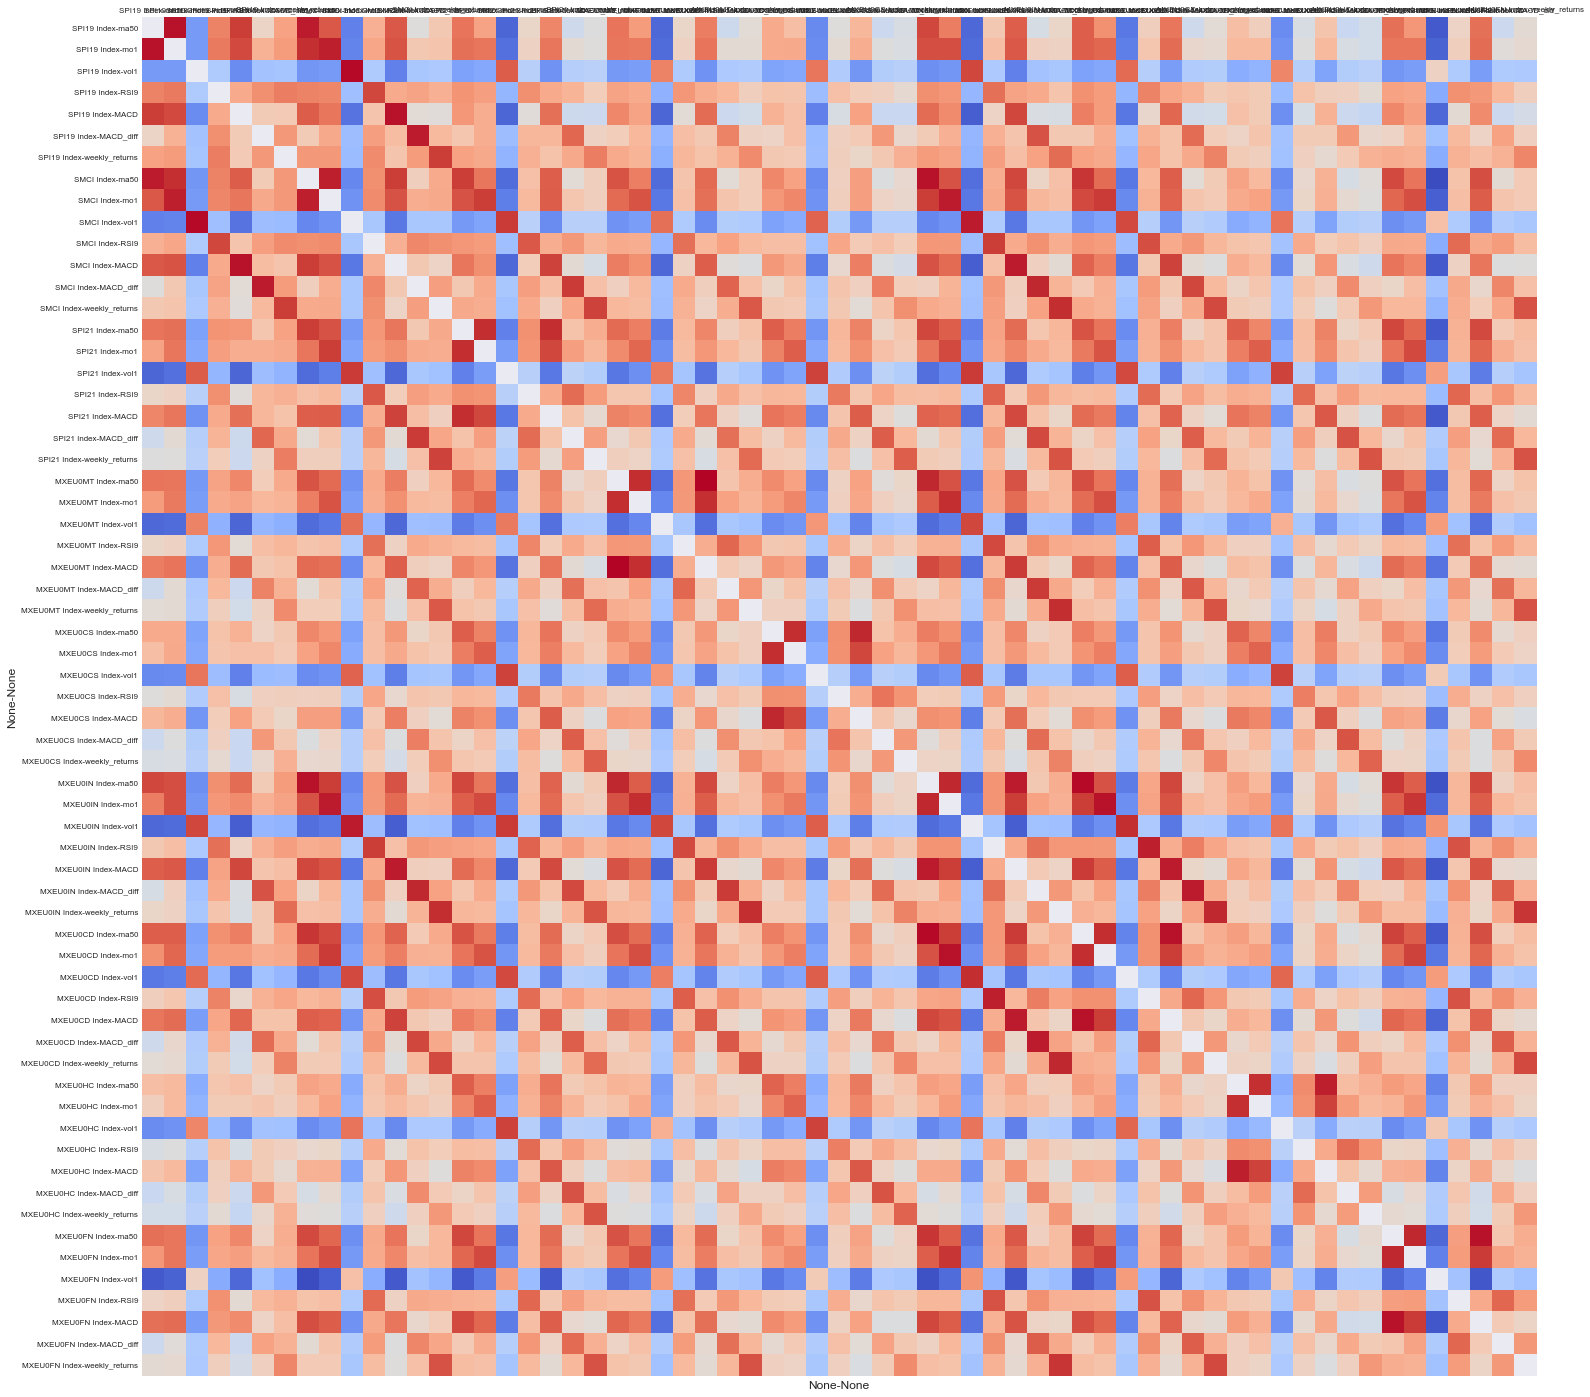

In [53]:
corr = data_plot.corr().round(2)

fig, ax = plt.subplots(figsize=(25,25))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=False, labeltop=True, length=0)
plt.show()